In [145]:
# Load libraries
from sklearn import model_selection
import os
import warnings
import time
import random as rnd
import scipy.io
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from sklearn.externals import joblib
# import joblib
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib import rc
import pandas
import seaborn as sn
# ignore all warnings
warnings.filterwarnings("ignore")

# ===========================================================================
# Here starts the main part of the script
#

In [146]:
def logistic_func(X1, bayta1, bayta2, bayta3, bayta4):
    logisticPart = 1 + np.exp(np.negative(np.divide(X1 - bayta3, np.abs(bayta4))))
    yhat = bayta2 + np.divide(bayta1 - bayta2, logisticPart)
    return yhat

In [147]:
def curve_bounds(x, params, sigma):
    upper_bound = logistic_func(x, params[0] + 2 * sigma[0], params[1] + 2 * sigma[1], params[2] + 2 * sigma[2], params[3] + 2 * sigma[3])
    lower_bound = logistic_func(x, params[0] - 2 * sigma[0], params[1] - 2 * sigma[1], params[2] - 2 * sigma[2], params[3] + 2 * sigma[3])
    return upper_bound, lower_bound

# Compare two algorithm

In [148]:
'''======================== parameters ================================'''
model_name = 'SVR'

resolution_op = '/all/' #'/all/'
fig_path = './fig/compare/'

data_name = 'KONVID_1K' #'YOUTUBE_UGC_ALL', 'KONVID_1K', 'COMBINED'
algo_name1 = 'VSFACNN'
algo_name2 = 'VSFACNN_Saliency'
fig_op = 'two' #'three' for saliency, nss, nss_saliency

In [149]:
df1 = pd.read_csv(f'./result{resolution_op}test_{data_name}_{algo_name1}_Predicted_Score.csv')
df1 = df1.rename(columns={'y_pred1': f'y_pred_{algo_name1}', 'MOS': f'MOS_{algo_name1}'})
# df1

In [150]:
df2 = pd.read_csv(f'./result/{resolution_op}test_{data_name}_{algo_name2}_Predicted_Score.csv')
df2 = df2.rename(columns={'y_pred1': f'y_pred_{algo_name2}', 'MOS': f'MOS_{algo_name2}'})
# df2

In [151]:
video_name1 = df1['Video_name'].tolist()
mos1 = df1[f'MOS_{algo_name1}'].tolist()
y_pred1 = df1[f'y_pred_{algo_name1}'].tolist()
y1 = df1[f'Predicted Score_{algo_name1}'].tolist()

video_name2 = df1['Video_name'].tolist()
mos2 = df2[f'MOS_{algo_name2}'].tolist()
y_pred2 = df2[f'y_pred_{algo_name2}'].tolist()
y2 = df2[f'Predicted Score_{algo_name2}'].tolist()

In [152]:
data = {'Video_name1': video_name1,
        'MOS1': mos1,
        'y_pred1': y_pred1,
        "Predicted Score_" + algo_name1: y1,

        'Video_name2': video_name2,
        'MOS2': mos2,
        'y_pred2': y_pred2,
        "Predicted Score_" + algo_name2: y2}
result = pandas.DataFrame(data)
mos1 = np.array(mos1, dtype=np.float64)
mos2 = np.array(mos2, dtype=np.float64)
y1 = np.array(y1, dtype=np.float64)
y2 = np.array(y2, dtype=np.float64)
result

,Video_name1,MOS1,y_pred1,Predicted Score_VSFACNN,Video_name2,MOS2,y_pred2,Predicted Score_VSFACNN_Saliency
0,10016324794.mp4,3.104036,2.843782,2.790517,10016324794.mp4,2.474540,2.626902,2.587701
1,10533906564.mp4,3.418784,3.502775,3.519246,10533906564.mp4,3.193964,3.211122,3.215725
2,10116604143.mp4,3.238928,2.646330,2.576051,10116604143.mp4,4.003316,4.033450,4.093716
3,6268902756.mp4,1.848571,1.737008,1.644177,6268902756.mp4,3.800978,3.767302,3.812868
4,8664958871.mp4,3.733532,3.561516,3.584383,8664958871.mp4,2.811770,3.025464,3.015393
...,...,...,...,...,...,...,...,...
235,12143576166.mp4,3.643604,4.011128,4.078411,12143576166.mp4,3.576158,3.320332,3.333553
236,8039356416.mp4,2.541986,2.717217,2.652701,8039356416.mp4,2.429576,2.134371,2.070646
237,10500520233.mp4,2.991626,3.353676,3.353719,10500520233.mp4,4.205654,3.305908,3.317997
238,11803329033.mp4,3.778496,3.561742,3.584633,11803329033.mp4,2.901698,3.181732,3.184005


In [153]:
if data_name == 'KONVID_1K':
    title_name = 'KoNViD-1k'
elif data_name == 'YOUTUBE_UGC_ALL':
    title_name = 'YouTube-UGC'

=======================VSFACNN===============================


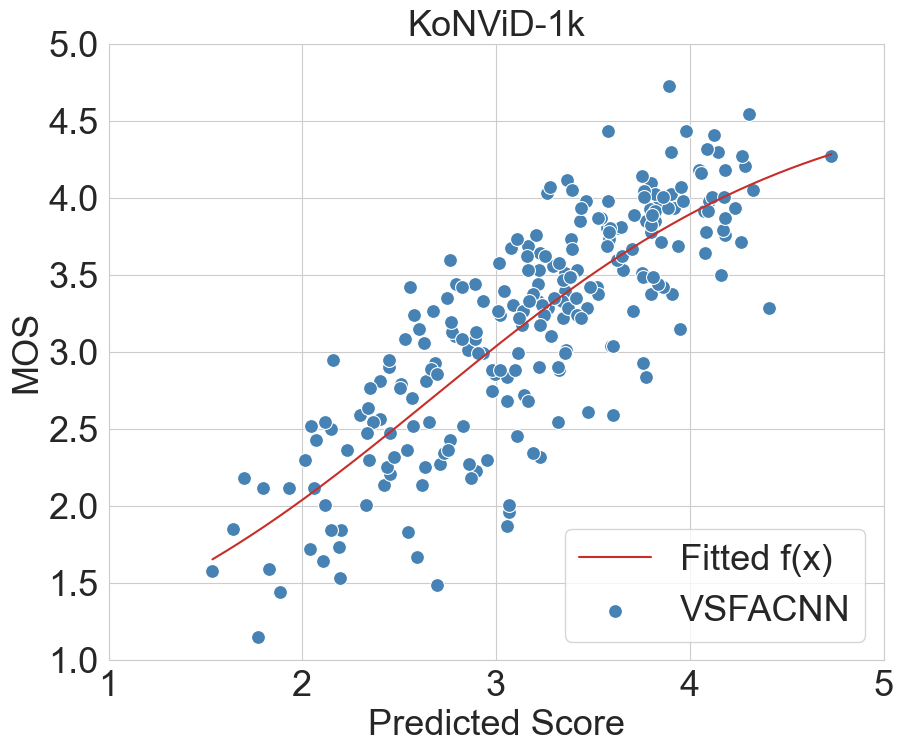

'test_KONVID_1K_VSFACNN.png'

In [154]:
print('=======================' + algo_name1 + '===============================')
# nonlinear logistic fitted curve / logistic regression
try:
    beta = [np.max(mos1), np.min(mos1), np.mean(y1), 0.5]
    popt, pcov = curve_fit(logistic_func, y1, mos1, p0=beta, maxfev=100000000)
    sigma = np.sqrt(np.diag(pcov))
except:
    raise Exception('Fitting logistic function time-out!!')
x_values1 = np.linspace(np.min(y1), np.max(y1), len(y1))
upper_bound, lower_bound = curve_bounds(x_values1, popt, sigma)

plt.rcParams.update({'font.size': 26})  # Set the font size to 26

plt.figure(figsize=(10, 8))  # Set the figure size (larger plot)

plt.plot(x_values1, logistic_func(x_values1, *popt), '-', color='#c72e29', label='Fitted f(x)')

# Uncomment these lines if you want to include upper and lower bounds in the plot
# plt.plot(x_values1, upper_bound, 'b--', label='f(x)±2σ')
# plt.plot(x_values1, lower_bound, 'b--', label='f(x)±2σ')

fig1 = sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result, markers='o', color='steelblue', label=algo_name1, s=100)  # Increase data point size (s=100)

# Set the legend to a location outside the plot and specify the bbox_to_anchor
plt.legend(loc='lower right', fontsize=26, bbox_to_anchor=(1.0, 0.0))

plt.ylim(1, 5)
plt.xlim(1, 5)

plt.title(title_name, fontsize=26)  # Set the title font size to 26
plt.xlabel('Predicted Score', fontsize=26)  # Set the xlabel font size to 26
plt.ylabel('MOS', fontsize=26)  # Set the ylabel font size to 26
plt.show()

reg_fig1 = fig1.get_figure()

# Save the figure as an EPS file
save_folder = './fig/all'
fig_name = 'test_' + data_name + '_' + algo_name1 + '.png'
save_path = os.path.join(save_folder, fig_name)
reg_fig1.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.close()

fig_name

========================VSFACNN_Saliency==============================


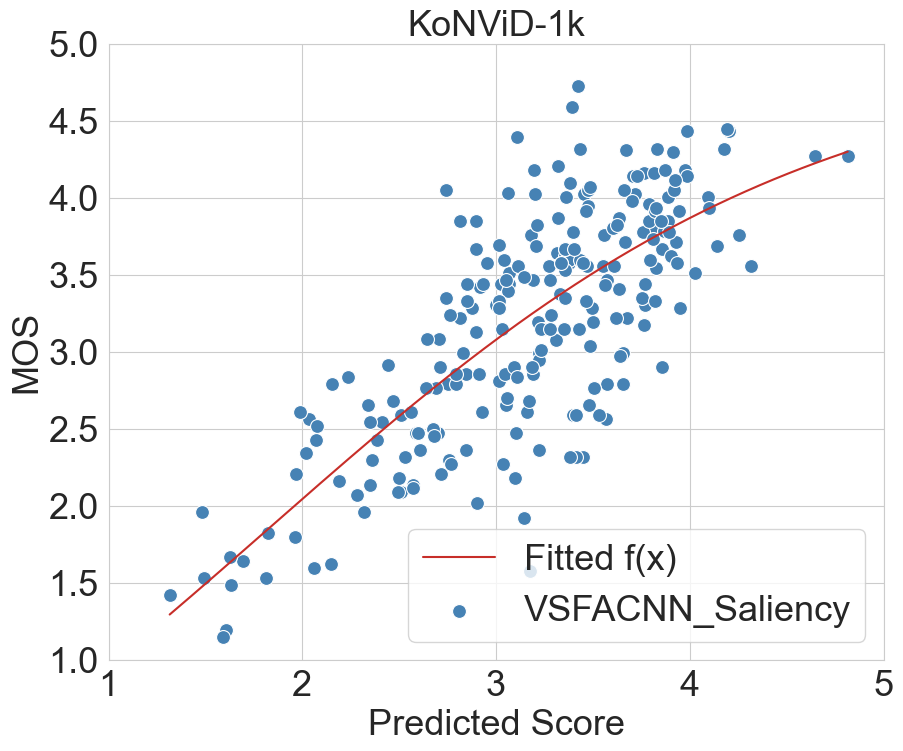

'test_KONVID_1K_VSFACNN_Saliency.png'

In [155]:
print('========================' + algo_name2 + '==============================')
# nonlinear logistic fitted curve / logistic regression
try:
    beta = [np.max(mos2), np.min(mos2), np.mean(y2), 0.5]
    popt, pcov = curve_fit(logistic_func, y2, mos2, p0=beta, maxfev=100000000)
    sigma = np.sqrt(np.diag(pcov))
except:
    raise Exception('Fitting logistic function time-out!!')
x_values2 = np.linspace(np.min(y2), np.max(y2), len(y2))
upper_bound, lower_bound = curve_bounds(x_values2, popt, sigma)

plt.rcParams.update({'font.size': 26})  # Set the font size to 26

plt.figure(figsize=(10, 8))  # Set the figure size (larger plot)

plt.plot(x_values2, logistic_func(x_values2, *popt), '-', color='#c72e29', label='Fitted f(x)')

# Uncomment these lines if you want to include upper and lower bounds in the plot
# plt.plot(x_values2, upper_bound, 'b--', label='f(x)±2σ')
# plt.plot(x_values2, lower_bound, 'b--', label='f(x)±2σ')

fig2 = sn.scatterplot(x="Predicted Score_" + algo_name2, y="MOS2", data=result, markers='X', color='steelblue', label=algo_name2, s=100)  # Increase data point size (s=100)

# Set the legend to a location outside the plot and specify the bbox_to_anchor
plt.legend(loc='lower right', fontsize=26, bbox_to_anchor=(1.0, 0.0))

plt.ylim(1, 5)
plt.xlim(1, 5)

plt.title(title_name, fontsize=26)  # Set the title font size to 26
plt.xlabel('Predicted Score', fontsize=26)  # Set the xlabel font size to 26
plt.ylabel('MOS', fontsize=26)  # Set the ylabel font size to 26
plt.show()

reg_fig2 = fig2.get_figure()

# Save the figure as an EPS file
save_folder = './fig/all'
fig_name = 'test_' + data_name + '_' + algo_name2 + '.png'
save_path = os.path.join(save_folder, fig_name)
reg_fig2.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.close()

fig_name

=========================ALL=============================


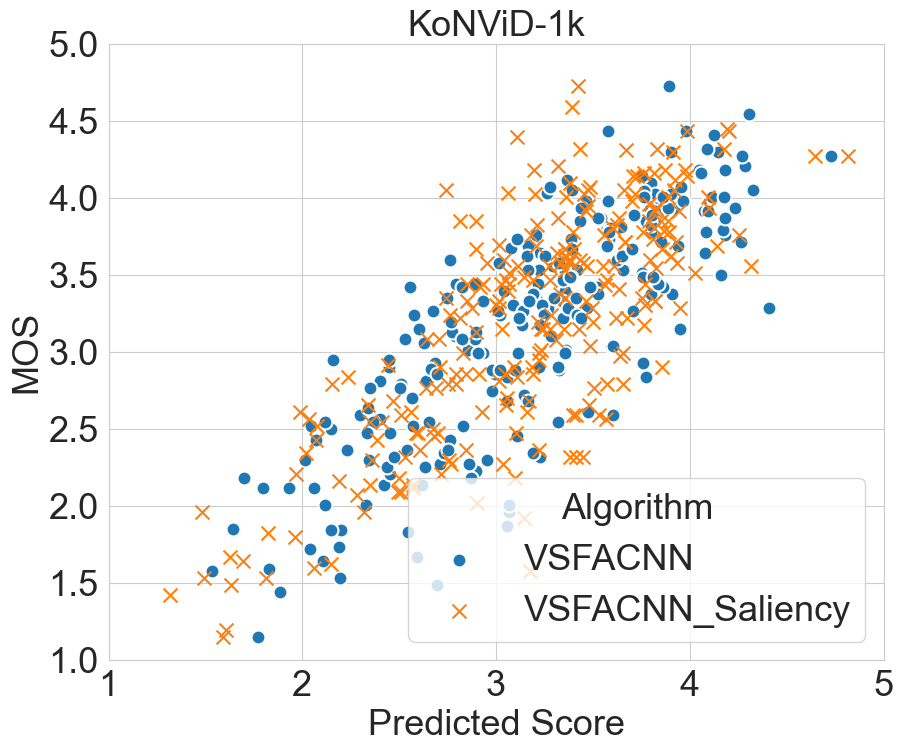

'./fig/compare/test_KONVID_1K_VSFACNN_vs_VSFACNN_Saliency.png'

In [156]:
if fig_op == 'two':
    print('=========================ALL=============================')
    # Create separate scatter plots for each algorithm with colorblind palette and different markers
    fig, ax = plt.subplots(figsize=(10,8))  # Set the figure size (larger plot)

    # scatter plot for two test dataset with increased marker size (s=100 in this example)
    sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result, ax=ax, palette='colorblind', marker='o', s=100, label=algo_name1)
    sn.scatterplot(x="Predicted Score_" + algo_name2, y="MOS2", data=result, ax=ax, palette='colorblind', marker='x', s=100, label=algo_name2)

    # Adjust marker edge width for each scatter plot
    for scatter_plot in ax.collections:
        scatter_plot.set_linewidth(1.5)

    plt.rcParams.update({'font.size': 26})  # Set the font size to 26

    # Set the legend to a location outside the plot and specify the bbox_to_anchor
    plt.legend(loc='lower right', title="Algorithm", fontsize=26, bbox_to_anchor=(1.0, 0.0))

    plt.ylim(1, 5)
    plt.xlim(1, 5)

    plt.title(title_name, fontsize=26)  # Set the title font size to 26
    plt.xlabel('Predicted Score', fontsize=26)  # Set the xlabel font size to 26
    plt.ylabel('MOS', fontsize=26)  # Set the ylabel font size to 26

    reg_fig = ax.get_figure()

    # Save the figure as an EPS file
    fig_name = fig_path + 'test_' + data_name + '_' + algo_name1 + '_vs_' + algo_name2 + '.png'
    reg_fig.savefig(fig_name, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

fig_name

In [157]:
if fig_op == 'three':
    algo_name3 = 'Saliency'
    df3 = pd.read_csv(f'./result/{resolution_op}test_{data_name}_{algo_name3}_Predicted_Score.csv')
    df3 = df3.rename(columns={'y_pred1': f'y_pred_{algo_name3}', 'MOS': f'MOS_{algo_name3}'})

    video_name3 = df1['Video_name'].tolist()
    mos3 = df3[f'MOS_{algo_name3}'].tolist()
    y_pred3 = df3[f'y_pred_{algo_name3}'].tolist()
    y3 = df3[f'Predicted Score_{algo_name3}'].tolist()

    data = {'Video_name1': video_name1,
            'MOS1': mos1,
            'y_pred1': y_pred1,
            "Predicted Score_" + algo_name1: y1,

            'Video_name2': video_name2,
            'MOS2': mos2,
            'y_pred2': y_pred2,
            "Predicted Score_" + algo_name2: y2,

            'Video_name3': video_name3,
            'MOS3': mos3,
            'y_pred3': y_pred3,
            "Predicted Score_" + algo_name3: y3}
    result = pd.DataFrame(data)
    mos1 = np.array(mos1, dtype=np.float64)
    mos2 = np.array(mos2, dtype=np.float64)
    mos3 = np.array(mos3, dtype=np.float64)
    y1 = np.array(y1, dtype=np.float64)
    y2 = np.array(y2, dtype=np.float64)
    y3 = np.array(y3, dtype=np.float64)

    print('=========================ALL=============================')

    # Create separate scatter plots for each algorithm with colorblind palette and different markers
    fig, ax = plt.subplots(figsize=(10,8))  # Set the figure size (larger plot)

    sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result, ax=ax, palette='colorblind', marker='o', s=100, label=algo_name1)
    sn.scatterplot(x="Predicted Score_" + algo_name2, y="MOS2", data=result, ax=ax, palette='colorblind', marker='x', s=100, label=algo_name2)
    sn.scatterplot(x="Predicted Score_" + algo_name3, y="MOS3", data=result, ax=ax, palette='colorblind', marker='+', s=100, label=algo_name3)

    # Adjust marker edge width for each scatter plot
    for scatter_plot in ax.collections:
        scatter_plot.set_linewidth(1.5)

    plt.rcParams.update({'font.size': 26})  # Set the font size to 26

    # Set the legend to a location outside the plot and specify the bbox_to_anchor
    plt.legend(loc='lower right', title="Algorithm", fontsize=26, bbox_to_anchor=(1.0, 0.0))

    plt.ylim(1, 5)
    plt.xlim(1, 5)

    plt.title(title_name, fontsize=26)  # Set the title font size to 26
    plt.xlabel('Predicted Score', fontsize=26)  # Set the xlabel font size to 26
    plt.ylabel('MOS', fontsize=26)  # Set the ylabel font size to 26
    plt.show()

    reg_fig = ax.get_figure()

    # Save the figure as an EPS file
    fig_name = fig_path + 'test_' + data_name + '_' + algo_name1 + '_vs_' + algo_name2 + '_vs_' + algo_name3 + '.png'
    reg_fig.savefig(fig_name, format='png', dpi=300, bbox_inches='tight')
    plt.close()

fig_name

'./fig/compare/test_KONVID_1K_VSFACNN_vs_VSFACNN_Saliency.png'

# Combined the datasets

In [158]:
data_name = 'COMBINED'
data_name1 = 'KONVID_1K'
data_name2 = 'YOUTUBE_UGC_ALL'

algo_name1 = 'NSS_VSFACNN'
df1 = pd.read_csv(f'./result/{resolution_op}test_{data_name1}_{algo_name1}_Predicted_Score.csv')
df1 = df1.rename(columns={'y_pred1': f'y_pred_{algo_name1}', 'MOS': f'MOS_{algo_name1}'})
df1['Data_Source'] = data_name1
df2 = pd.read_csv(f'./result/{resolution_op}test_{data_name2}_{algo_name1}_Predicted_Score.csv')
df2 = df2.rename(columns={'y_pred1': f'y_pred_{algo_name1}', 'MOS': f'MOS_{algo_name1}'})
df2['Data_Source'] = data_name2

merged_algo1 = pd.concat([df1, df2], ignore_index=True)

data_source1 = merged_algo1['Data_Source'].tolist()
video_name1 = merged_algo1['Video_name'].tolist()
mos1 = merged_algo1[f'MOS_{algo_name1}'].tolist()
y_pred1 = merged_algo1[f'y_pred_{algo_name1}'].tolist()
y1 = merged_algo1[f'Predicted Score_{algo_name1}'].tolist()

data1 = {'Video_name1': video_name1,
        'MOS1': mos1,
        'y_pred1': y_pred1,
        'Predicted Score_' + algo_name1: y1,
         'Data_Source': data_source1}
result1 = pandas.DataFrame(data1)
mos1 = np.array(mos1, dtype=np.float64)
y1 = np.array(y1, dtype=np.float64)
result1.columns

Index(['Video_name1', 'MOS1', 'y_pred1', 'Predicted Score_NSS_VSFACNN',
       'Data_Source'],
      dtype='object')

In [159]:
algo_name2 = 'NSS_VSFACNN_Saliency'
df1 = pd.read_csv(f'./result/{resolution_op}test_{data_name1}_{algo_name2}_Predicted_Score.csv')
df1 = df1.rename(columns={'y_pred1': f'y_pred_{algo_name2}', 'MOS': f'MOS_{algo_name2}'})
df1['Data_Source'] = data_name1
df2 = pd.read_csv(f'./result/{resolution_op}test_{data_name2}_{algo_name2}_Predicted_Score.csv')
df2 = df2.rename(columns={'y_pred1': f'y_pred_{algo_name2}', 'MOS': f'MOS_{algo_name2}'})
df2['Data_Source'] = data_name2
merged_algo2 = pd.concat([df1, df2], ignore_index=True)

data_source2 = merged_algo2['Data_Source'].tolist()
video_name2 = merged_algo2['Video_name'].tolist()
mos2 = merged_algo2[f'MOS_{algo_name2}'].tolist()
y_pred2 = merged_algo2[f'y_pred_{algo_name2}'].tolist()
y2 = merged_algo2[f'Predicted Score_{algo_name2}'].tolist()
data2 = {'Video_name2': video_name2,
        'MOS2': mos2,
        'y_pred2': y_pred2,
        'Predicted Score_' + algo_name2: y2,
         'Data_Source': data_source2}
result2 = pandas.DataFrame(data2)
mos2 = np.array(mos2, dtype=np.float64)
y2 = np.array(y2, dtype=np.float64)
result2.columns

Index(['Video_name2', 'MOS2', 'y_pred2',
       'Predicted Score_NSS_VSFACNN_Saliency', 'Data_Source'],
      dtype='object')

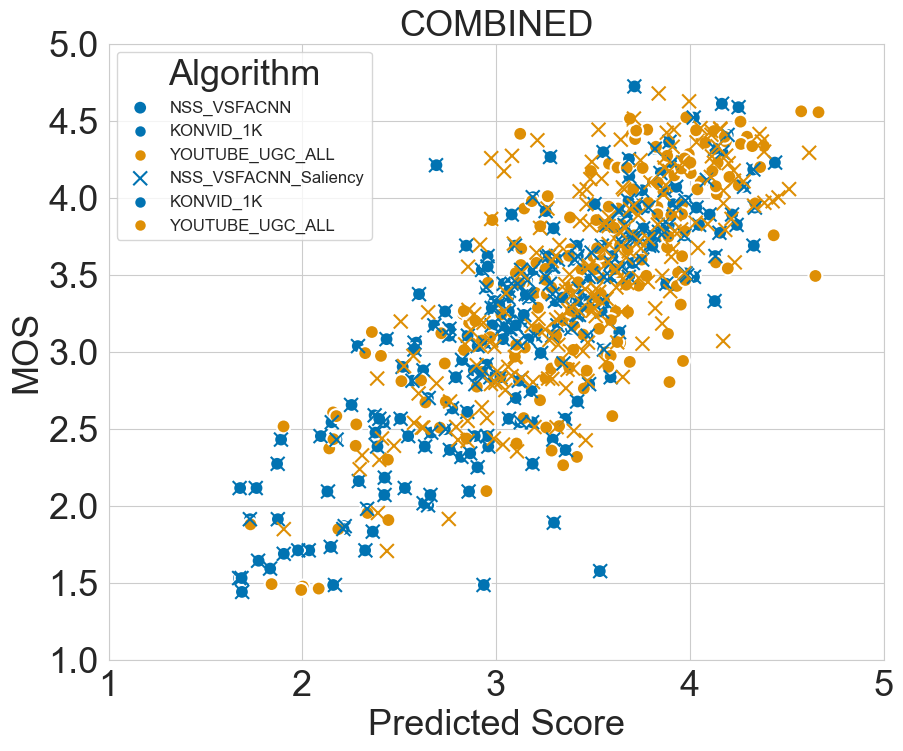

In [160]:
# Define color and marker settings
data_source_colors = {'KONVID_1K': 'blue', 'YOUTUBE_UGC_ALL': 'orange'}
algo_name_markers = {'Predicted Score_' + algo_name1: 'o', 'Predicted Score_' + algo_name2: 'x'}

# Create separate scatter plots for each algorithm with colorblind palette and different markers
fig, ax = plt.subplots(figsize=(10, 8))  # Set the figure size (larger plot)

# scatter plot for two test dataset with specified colors and markers and increased marker size (s=100 in this example)
sn.scatterplot(x="Predicted Score_" + algo_name1, y="MOS1", data=result1, ax=ax, hue='Data_Source', marker=algo_name_markers["Predicted Score_" + algo_name1], palette='colorblind', label=algo_name1, linewidth=0.5, s=100)
sn.scatterplot(x="Predicted Score_" + algo_name2, y="MOS2", data=result2, ax=ax, hue='Data_Source', marker=algo_name_markers["Predicted Score_" + algo_name2], palette='colorblind', label=algo_name2, linewidth=0.5, s=100)

# Adjust marker edge width for each scatter plot
for scatter_plot in ax.collections:
    scatter_plot.set_linewidth(1.5)

plt.rcParams.update({'font.size': 26})  # Set the font size to 26

# Make the legend smaller and set the font size to 26 for the legend title
plt.legend(loc='upper left', title="Algorithm", prop={'size': 12}, fontsize=26)

plt.ylim(1, 5)
plt.xlim(1, 5)
plt.title(data_name, fontsize=26)  # Set the title font size to 26
plt.xlabel('Predicted Score', fontsize=26)  # Set the xlabel font size to 26
plt.ylabel('MOS', fontsize=26)  # Set the ylabel font size to 26
plt.show()

reg_fig = ax.get_figure()

# Save the figure as an EPS file
# fig_name = fig_path + 'test_' + data_name + '_' + algo_name1 + '_vs_' + algo_name2 + '.png'
# reg_fig.savefig(fig_name, format='png', dpi=600, bbox_inches='tight')
plt.close()